In [3]:
from typing import List, Tuple, Dict, Any, Optional
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [49]:
# BASE_PATH = "../program_bank/v045/2025_03_05__01_24/"  # 1h - 2 generators
BASE_PATH = "../program_bank/v045/2025_03_05__02_33"  # 8h - 2 generators
# BASE_PATH = "../program_bank/v043/2025_02_28__00_40" # 1 h - 3 platforms - Rust and Cpp
# BASE_PATH = "../program_bank/v045/2025_03_05__00_59" # 10 programs - 2 generators (w converter) - 3 platforms - Rust and Cpp
# BASE_PATH = "../program_bank/v045/2025_03_05__01_04" # 200 programs / 10 min - 2 generators (w converter) - 3 platforms - Rust and Cpp
# BASE_PATH = "../program_bank/v042/2025_02_28__00_08"  # 15 min - 3 platforms - Rust and Cpp
# BASE_PATH = "../program_bank/v041/2025_02_27__19_49"  # 10 progams - Rust and Cpp
# BASE_PATH = "../program_bank/v040/2025_02_24__14_25"  # 1h - 3 platforms << latest in paper
# BASE_PATH = "../program_bank/v038/2025_02_22__23_13"  # 100 programs - 3 platforms

OPTION_A = "../program_bank/v046/2025_03_05__17_47"  # 1h - 3 platforms

# PY_COVERAGE_PATH = os.path.join(BASE_PATH, "coverage.xml")
# RUST_COVERAGE_PATH = os.path.join(BASE_PATH, "rust_coverage.xml")
# CPP_COVERAGE_PATH = os.path.join(BASE_PATH, "cpp_coverage.xml")
# CONVERTER_COVERAGE_PATH = os.path.join(BASE_PATH, "converter_coverage.xml")
MERGED_COVERAGE_PATH = os.path.join(BASE_PATH, "merged_coverage.xml")


# 1 h
MORPHQ_PATH = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v14"

# 5 min
# MORPHQ_PATH = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v13"
MORPHQ_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "coverage.xml")
MORPHQ_RUST_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "rust_coverage.xml")

MORPHQ_MERGED_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "merged_coverage.xml")

platforms = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]

In [50]:
import xml.etree.ElementTree as ET


def merge_cobertura_reports(report1_path, report2_path, output_path):
    tree1 = ET.parse(report1_path)
    root1 = tree1.getroot()

    tree2 = ET.parse(report2_path)
    root2 = tree2.getroot()

    # Merge `<packages>` elements
    packages1 = root1.find("packages")
    packages2 = root2.find("packages")

    if packages1 is not None and packages2 is not None:
        for package in packages2.findall("package"):
            packages1.append(package)

    # Save merged XML
    tree1.write(output_path)


def prepare_xml(base_path: str):
    """
    Prepare XML coverage files by merging multiple coverage files into one.

    Args:
        base_path (str): Base path containing the coverage files
    """
    # Get paths for different coverage files
    py_coverage = os.path.join(base_path, "coverage.xml")
    rust_coverage = os.path.join(base_path, "rust_coverage.xml")
    cpp_coverage = os.path.join(base_path, "cpp_coverage.xml")
    converter_coverage = os.path.join(base_path, "converter_coverage.xml")
    merged_coverage = os.path.join(base_path, "merged_coverage.xml")

    # Merge Python and Rust coverage
    merge_cobertura_reports(
        report1_path=py_coverage,
        report2_path=rust_coverage,
        output_path=merged_coverage
    )

    # Add C++ coverage
    merge_cobertura_reports(
        report1_path=cpp_coverage,
        report2_path=merged_coverage,
        output_path=merged_coverage
    )

    # Add converter coverage if exists
    if os.path.exists(converter_coverage):
        merge_cobertura_reports(
            report1_path=merged_coverage,
            report2_path=converter_coverage,
            output_path=merged_coverage
        )


merge_cobertura_reports(
    report1_path=MORPHQ_COVERAGE_PATH,
    report2_path=MORPHQ_RUST_COVERAGE_PATH,
    output_path=MORPHQ_MERGED_COVERAGE_PATH
)

In [52]:
prepare_xml(base_path=OPTION_A)
# prepare_xml(base_path=OPTION_B)

In [ ]:
def get_coverage_info(platforms: List[str],
                      coverage_path: str) -> Dict[str, Dict[str, Any]]:
    """
    Given a list of platforms, returns the coverage information for each platform.

    Args:
        platforms (List[str]): List of platform names to extract coverage information for.
        coverage_path (str): Path to the coverage XML file.

    Returns:
        Dict[str, Dict[str, Any]]: Dictionary containing coverage information for each platform.
    """
    import xml.etree.ElementTree as ET

    # Parse the coverage.xml file
    tree = ET.parse(coverage_path)
    root = tree.getroot()

    # Initialize counters for each package
    package_coverage = {platform: {'covered': 0, 'total': 0, 'covered_lines': [
    ], 'total_lines': []} for platform in platforms}
    qiskit_lines = []
    covered_qiskit_lines = []

    # Extract package information
    packages = root.find('packages')
    for package in packages.findall('package'):
        package_name = package.get('name')

        # Extract class information
        classes = package.find('classes')
        for cls_obj in classes.findall('class'):
            # Extract line information
            lines = cls_obj.find('lines')
            for line in lines.findall('line'):
                # exclude test cases
                if "test" in cls_obj.get('filename'):
                    continue
                # exclude hpp files
                if cls_obj.get('filename').endswith(".hpp"):
                    continue
                hits = int(line.get('hits'))
                package_key = None
                for platform_name in package_coverage.keys():
                    if f"/site-packages/{platform_name}/" in cls_obj.get(
                            'filename'):
                        package_key = platform_name
                        break
                if "crates" in package_name:
                    package_key = "qiskit"
                if cls_obj.get('filename').endswith(".cpp") or cls_obj.get(
                        'filename').endswith(".cpp"):
                    package_key = "pytket"
                if package_key is None:
                    # by default the colletion of coverage done from the
                    # qiskit installation folder have relative paths
                    # thus they refer to the qiskit package
                    package_key = "qiskit"
                if package_key:
                    package_coverage[package_key]['total'] += 1
                    line_formatted = f"{cls_obj.get('filename')}:{line.get('number')}"
                    for prefix in [
                        "/home/regularuser/qiskit/qiskit/",
                        "/home/regularuser/.venv/lib/python3.12/site-packages/qiskit/",
                        "/home/regularuser/.venv/lib/python3.12/site-packages/pytket/",
                        "/home/regularuser/.venv/lib/python3.12/site-packages/pennylane/"
                    ]:
                        if line_formatted.startswith(prefix):
                            line_formatted = line_formatted[len(prefix):]
                    package_coverage[package_key]["total_lines"].append(
                        line_formatted)
                    if hits > 0:
                        package_coverage[package_key]["covered_lines"].append(
                            line_formatted)
                        package_coverage[package_key]['covered'] += 1

    # make sure there are no duplicates
    for package in package_coverage.keys():
        package_coverage[package]["total_lines"] = list(
            set(package_coverage[package]["total_lines"]))
        package_coverage[package]["covered_lines"] = list(
            set(package_coverage[package]["covered_lines"]))
        package_coverage[package]["total"] = len(
            package_coverage[package]["total_lines"])
        package_coverage[package]["covered"] = len(
            package_coverage[package]["covered_lines"])

    # Add percentage coverage
    for package, coverage in package_coverage.items():
        total_lines = coverage['total']
        covered_lines = coverage['covered']
        coverage_percentage = (
            covered_lines / total_lines) * 100 if total_lines > 0 else 0
        package_coverage[package]['coverage'] = coverage_percentage

    qiskit_lines = package_coverage["qiskit"]["total_lines"]
    covered_qiskit_lines = package_coverage["qiskit"]["covered_lines"]

    return package_coverage, qiskit_lines, covered_qiskit_lines


def get_platform_coverage(base_path: str) -> dict:
    """
    Get coverage information for different quantum platforms from a merged coverage file.

    Args:
        base_path (str): Path to the directory containing the merged coverage file

    Returns:
        dict: Coverage information for each platform
    """
    merged_coverage_path = os.path.join(base_path, "merged_coverage.xml")

    package_coverage, qiskit_lines, covered_lines = get_coverage_info(
        platforms, merged_coverage_path)

    # Print coverage information
    for package, coverage in package_coverage.items():
        print(
            f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")

    return package_coverage, qiskit_lines, covered_lines


# Example usage
package_coverage_ours, qiskit_lines_ours, covered_lines_ours = get_platform_coverage(
    base_path=BASE_PATH)
package_coverage_optionA, qiskit_lines_optionA, covered_lines_optionA = get_platform_coverage(
    base_path=OPTION_A)

qiskit_________: 10.23% (7439/72751)
pennylane______: 27.01% (12834/47509)
pytket_________: 9.93% (3815/38416)
qiskit_________: 9.06% (1335/14738)
pennylane______: 0.00% (0/0)
pytket_________: 1.17% (364/31028)


In [45]:
len(package_coverage_ours["qiskit"]["total_lines"])
print(len(set(qiskit_lines_ours)))

72751


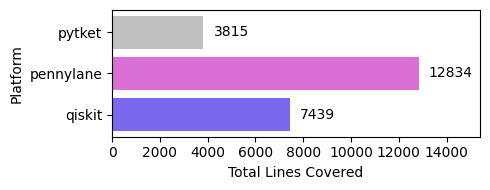

\newcommand{\QITEQiskitTotalLines}{72751}
\newcommand{\QITEPennylaneTotalLines}{47509}
\newcommand{\QITEPytketTotalLines}{38416}
\newcommand{\QITEQiskitCoveredLines}{7439}
\newcommand{\QITEPennylaneCoveredLines}{12834}
\newcommand{\QITEPytketCoveredLines}{3815}


In [8]:
# Create a dictionary for platform name to color
platform_colors = {
    'qiskit': 'mediumslateblue',
    'pytket': 'silver',
    'pennylane': 'orchid'
}

# Extract the colors for the platforms
colors = [platform_colors[platform] for platform in platforms]

# Initialize total_lines_covered with the total lines covered for each platform
total_lines_covered = [package_coverage_ours[platform]['covered']
                       for platform in platforms]

# Create a horizontal bar plot with the specified colors
fig, ax = plt.subplots(figsize=(5, 2))
bars = ax.barh(platforms, total_lines_covered, color=colors)
ax.set_xlabel('Total Lines Covered')
ax.set_ylabel('Platform')

max_val = max(total_lines_covered)

# Add the number on the column, left aligned
for bar, value in zip(bars, total_lines_covered):
    ax.text(value + (max_val / 30), bar.get_y() + bar.get_height() / 2,
            f'{value}', va='center', ha='left')

ax.set_xlim(0, max_val * 1.2)

fig.tight_layout()
plt.show()

# Save the plot as a PDF file
output_path_bar_plot = os.path.join("images", "platform_coverage_bar_plot.pdf")
fig.savefig(output_path_bar_plot)
# Print new commands for the different platforms total lines
for platform in platforms:
    total_lines = package_coverage_ours[platform]['total']
    print(
        f"\\newcommand{{\\QITE{platform.capitalize()}TotalLines}}{{{total_lines}}}")

# Print new commands for the different platforms covered lines
for platform in platforms:
    covered_lines = package_coverage_ours[platform]['covered']
    print(
        f"\\newcommand{{\\QITE{platform.capitalize()}CoveredLines}}{{{covered_lines}}}")

In [9]:
import random
pennylane_covered = package_coverage_ours["pennylane"]["covered_lines"]
pennylane_total = package_coverage_ours["pennylane"]["total_lines"]


# Set the seed for reproducibility
random.seed(42)

# Calculate the uncovered lines
pennylane_uncovered = set(pennylane_total) - set(pennylane_covered)

# Sample 30 lines from each group
sampled_covered = random.sample(
    pennylane_covered, min(30, len(pennylane_covered)))
sampled_uncovered = random.sample(
    pennylane_uncovered, min(30, len(pennylane_uncovered)))

# Print the sampled lines
print("Sampled Covered Lines:")
for line in sampled_covered:
    print(line)

print("\nSampled Uncovered Lines:")
for line in sampled_uncovered:
    print(line)

Sampled Covered Lines:
optimize/rms_prop.py:15
drawer/draw.py:19
data/base/dataset.py:29
ops/qutrit/observables.py:316
gradients/parameter_shift_hessian.py:442
templates/subroutines/mod_exp.py:197
ops/channel.py:138
templates/embeddings/angle.py:85
ops/qubit/parametric_ops_single_qubit.py:177
templates/subroutines/fermionic_double_excitation.py:511
transforms/decompose.py:326
math/single_dispatch.py:857
transforms/decompose.py:335
numpy/__init__.py:102
tape/qscript.py:971
optimize/riemannian_gradient.py:21
gradients/spsa_gradient.py:22
templates/layers/strongly_entangling.py:169
templates/state_preparations/arbitrary_state_preparation.py:135
ops/op_math/controlled_ops.py:1047
templates/subroutines/qdrift.py:75
capture/flatfn.py:20
_grad.py:32
measurements/measurements.py:499
transforms/unitary_to_rot.py:18
transforms/__init__.py:301
ops/cv.py:590
devices/_legacy_device.py:222
ops/op_math/symbolicop.py:200
ops/op_math/controlled_ops.py:108

Sampled Uncovered Lines:
qchem/spin.py:169
ops

/tmp/ipykernel_2045729/1046866828.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_uncovered = random.sample(


<Figure size 1200x600 with 0 Axes>

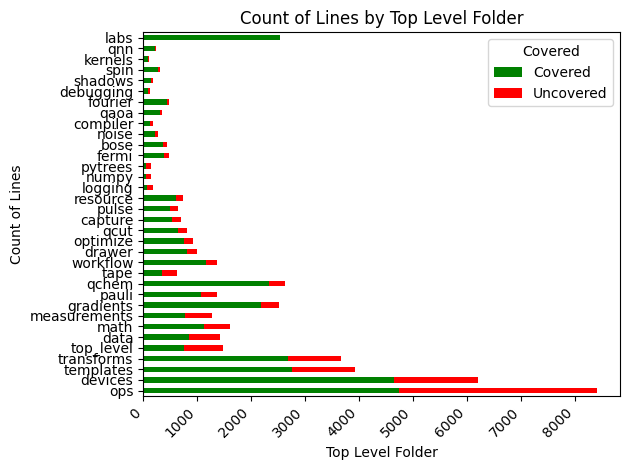

In [10]:
# create a table with the filename, the line number, if covered, and the first level folder of the path ("top_level" if the file is in the root of the project)
data = []

pennylane_total = package_coverage_ours["pennylane"]["total_lines"]
pennylane_covered = package_coverage_ours["pennylane"]["covered_lines"]

# Combine covered and uncovered lines
all_lines = set(pennylane_total)
covered_lines_set = set(pennylane_covered)

for line in all_lines:
    file_path, line_number = line.split(':')
    covered = line in covered_lines_set
    top_level_folder = file_path.split(
        '/')[0] if '/' in file_path else "top_level"
    data.append({
        'filename': file_path,
        'line_number': int(line_number),
        'covered': covered,
        'top_level_folder': top_level_folder
    })

# Create DataFrame
df = pd.DataFrame(data)
df.head()

# Group by top_level_folder and count covered/uncovered lines
grouped = df.groupby(
    ['top_level_folder', 'covered']).size().unstack(
    fill_value=0)
grouped = grouped.sort_values(
    by=[True, False],
    ascending=False)  # Sort by covered lines first

# Create stacked bar plot
plt.figure(figsize=(12, 6))
grouped.plot(kind='barh', stacked=True, color=['green', 'red'])
plt.title('Count of Lines by Top Level Folder')
plt.xlabel('Top Level Folder')
plt.ylabel('Count of Lines')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Covered', labels=['Covered', 'Uncovered'])
plt.tight_layout()
plt.show()

In [11]:

package_coverage_morphq, qiskit_lines_morphq, covered_lines_morphq_1h = get_coverage_info(
    platforms, MORPHQ_MERGED_COVERAGE_PATH)
for package, coverage in package_coverage_morphq.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")
qiskit_lines_morphq[:5]

qiskit_________: 9.49% (6904/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)


['providers/fake_provider/utils/backend_converter.py:77',
 'circuit/library/standard_gates/s.py:345',
 'circuit/quantumcircuit.py:6505',
 'synthesis/evolution/product_formula.py:190',
 'qobj/qasm_qobj.py:696']

Size of qiskit_lines_ours: 72751
Size of qiskit_lines_morphq: 72751

Elements in qiskit_lines_ours but not in qiskit_lines_morphq: 0

Elements in qiskit_lines_morphq but not in qiskit_lines_ours: 0


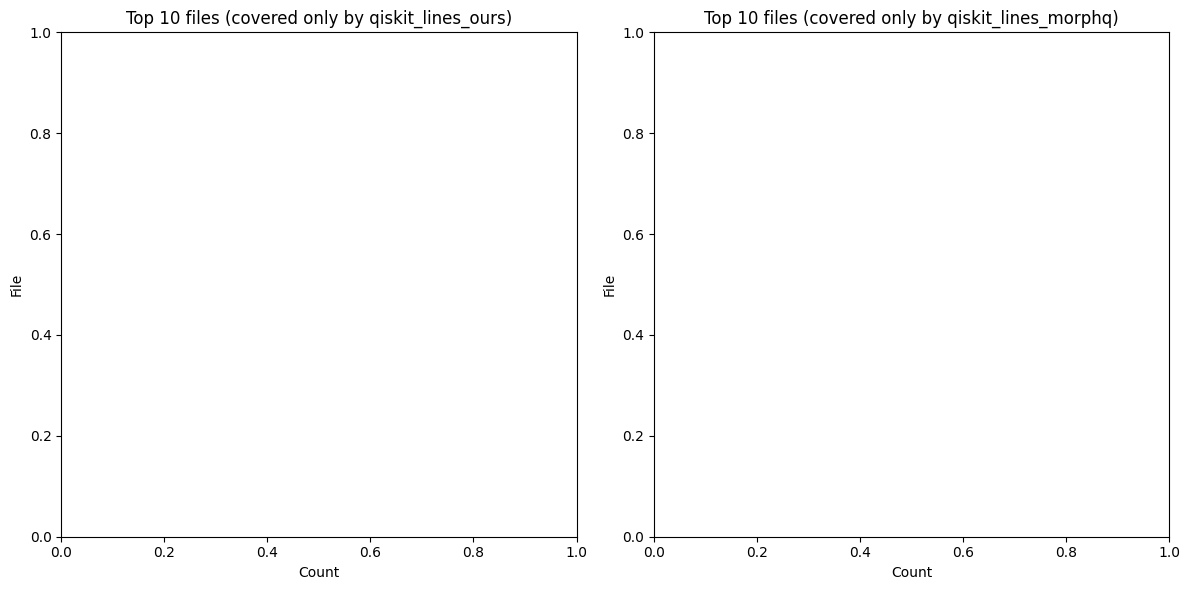

In [ ]:
def compare_sets(
        set1, set2, name1="Set 1", name2="Set 2", top_k=10, color1="blue",
        color2="red"):
    """
    Compare two sets and print their differences in a formatted way.

    Args:
        set1: First set to compare
        set2: Second set to compare
        name1: Name identifier for first set
        name2: Name identifier for second set
        top_k: Number of elements to print from each difference (default: 10)

    Returns:
        None
    """
    set1_unique = set(set1)
    set2_unique = set(set2)

    # Difference in sizes
    print(f"Size of {name1}: {len(set1_unique)}")
    print(f"Size of {name2}: {len(set2_unique)}")

    # Elements present in set1 but not in set2
    diff_set1 = set1_unique - set2_unique
    print(f"\nElements in {name1} but not in {name2}: {len(diff_set1)}")
    for item in sorted(diff_set1)[:top_k]:
        print(f"  {item}")

    # Elements present in set2 but not in set1
    diff_set2 = set2_unique - set1_unique
    print(f"\nElements in {name2} but not in {name1}: {len(diff_set2)}")
    for item in sorted(diff_set2)[:top_k]:
        print(f"  {item}")

    # remove the line number:
    diff_set1_files = [line.split(":")[0] for line in diff_set1]
    diff_set2_files = [line.split(":")[0] for line in diff_set2]

    # print countplot of the differences make it horizontal and keep only the
    # top 10 most popular files
    # two plots next to each other
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.countplot(y=diff_set1_files, ax=ax[0], order=pd.Series(
        diff_set1_files).value_counts().index[:top_k], color=color1)
    ax[0].set_title(f"Top {top_k} files (covered only by {name1})")
    ax[0].set_ylabel('File')
    ax[0].set_xlabel('Count')

    sns.countplot(y=diff_set2_files, ax=ax[1], order=pd.Series(
        diff_set2_files).value_counts().index[:top_k], color=color2)
    ax[1].set_title(f"Top {top_k} files (covered only by {name2})")
    ax[1].set_ylabel('File')
    ax[1].set_xlabel('Count')

    plt.tight_layout()
    plt.show()


# Example usage
compare_sets(qiskit_lines_ours, qiskit_lines_morphq,
             "qiskit_lines_ours", "qiskit_lines_morphq")

In [ ]:
# Two paths to compare coverage
COMPARISON_PATH_NEW = "../program_bank/v045/2025_03_05__02_33"
COMPARISON_PATH_OLD = "../program_bank/v043/2025_02_28__00_40/"
COMPARISON_PATH_OLD_RERUN = "../program_bank/v046/2025_03_05__17_47/"

# Get coverage info for both paths
package_coverage_new, qiskit_lines_new, covered_lines_new = get_coverage_info(
    platforms, os.path.join(COMPARISON_PATH_NEW, "merged_coverage.xml"))

package_coverage_old, qiskit_lines_old, covered_lines_old = get_coverage_info(
    platforms, os.path.join(COMPARISON_PATH_OLD, "merged_coverage.xml"))

package_coverage_old_rerun, qiskit_lines_old_rerun, covered_lines_old_rerun = get_coverage_info(
    platforms, os.path.join(COMPARISON_PATH_OLD_RERUN, "coverage.xml"))
# clean lines by removing the first part of the path
# "/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/"
qiskit_lines_old_rerun = [
    re.sub(
        r"/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/",
        "", line) for line in qiskit_lines_old_rerun]
covered_lines_old_rerun = [
    re.sub(
        r"/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/",
        "", line) for line in covered_lines_old_rerun]

# Print coverage percentages for both paths
print(f"New path coverage:")
for package, coverage in package_coverage_new.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")

print(f"\nOld path coverage:")
for package, coverage in package_coverage_old.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")

print(f"\nOld path coverage (rerun):")
for package, coverage in package_coverage_old_rerun.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")

New path coverage:
qiskit_________: 10.23% (7439/72751)
pennylane______: 27.01% (12834/47509)
pytket_________: 9.93% (3815/38416)

Old path coverage:
qiskit_________: 10.67% (7764/72751)
pennylane______: 2.47% (1173/47509)
pytket_________: 25.69% (9480/36907)

Old path coverage (rerun):
qiskit_________: 5.65% (3275/58013)
pennylane______: 2.51% (1194/47509)
pytket_________: 5.96% (285/4779)


--------------------------------------------------------------------------------
Python and Rust Comparison:

PY files comparison:

Covered Lines Comparison (New vs Old Path) (py):
Size of New Path (py): 5542
Size of Old Path (py): 3251

Elements in New Path (py) but not in Old Path (py): 2300
  circuit/add_control.py:100
  circuit/add_control.py:102
  circuit/add_control.py:103
  circuit/add_control.py:104
  circuit/add_control.py:105
  circuit/add_control.py:106
  circuit/add_control.py:108
  circuit/add_control.py:109
  circuit/add_control.py:116
  circuit/add_control.py:117

Elements in Old Path (py) but not in New Path (py): 9
  circuit/library/standard_gates/u1.py:245
  circuit/library/standard_gates/u1.py:246
  circuit/library/standard_gates/u1.py:253
  circuit/library/standard_gates/u1.py:254
  circuit/library/standard_gates/u1.py:255
  circuit/library/standard_gates/u1.py:262
  circuit/library/standard_gates/u1.py:263
  circuit/library/standard_gates/u1.py:265
  circuit/librar

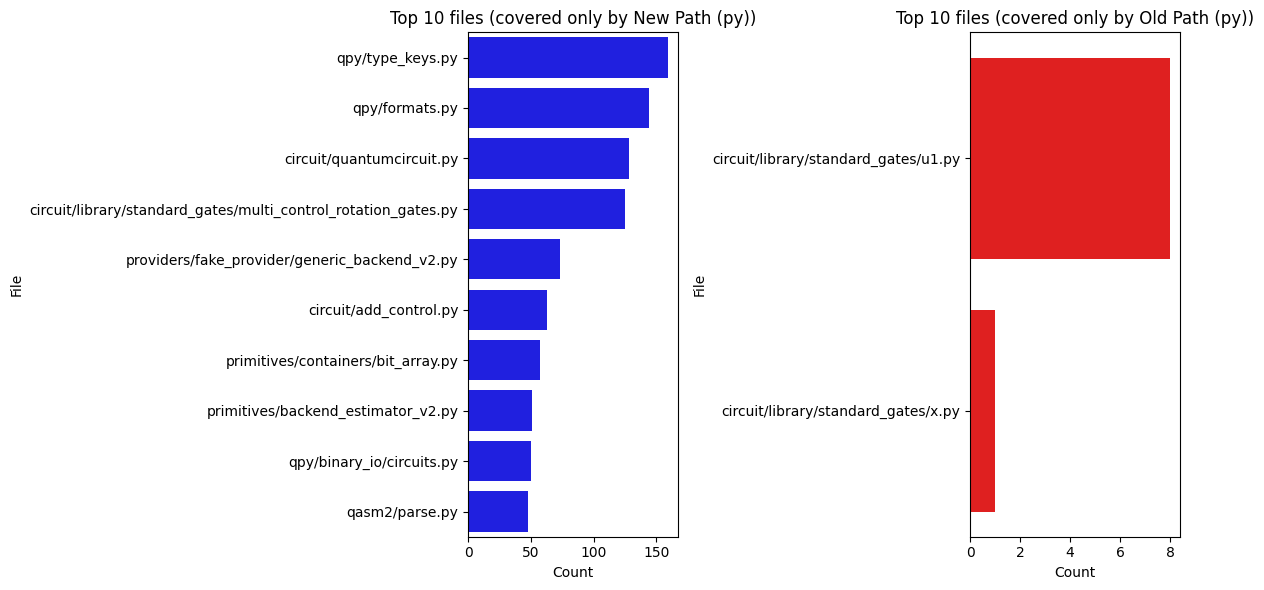


RS files comparison:

Covered Lines Comparison (New vs Old Path) (rs):
Size of New Path (rs): 1897
Size of Old Path (rs): 4513

Elements in New Path (rs) but not in Old Path (rs): 113
  crates/accelerate/src/euler_one_qubit_decomposer.rs:252
  crates/accelerate/src/euler_one_qubit_decomposer.rs:800
  crates/accelerate/src/euler_one_qubit_decomposer.rs:802
  crates/accelerate/src/euler_one_qubit_decomposer.rs:803
  crates/accelerate/src/euler_one_qubit_decomposer.rs:804
  crates/accelerate/src/euler_one_qubit_decomposer.rs:805
  crates/accelerate/src/euler_one_qubit_decomposer.rs:806
  crates/accelerate/src/euler_one_qubit_decomposer.rs:807
  crates/accelerate/src/euler_one_qubit_decomposer.rs:808
  crates/accelerate/src/euler_one_qubit_decomposer.rs:809

Elements in Old Path (rs) but not in New Path (rs): 2729
  crates/accelerate/src/convert_2q_block_matrix.rs:100
  crates/accelerate/src/convert_2q_block_matrix.rs:101
  crates/accelerate/src/convert_2q_block_matrix.rs:103
  crates/acc

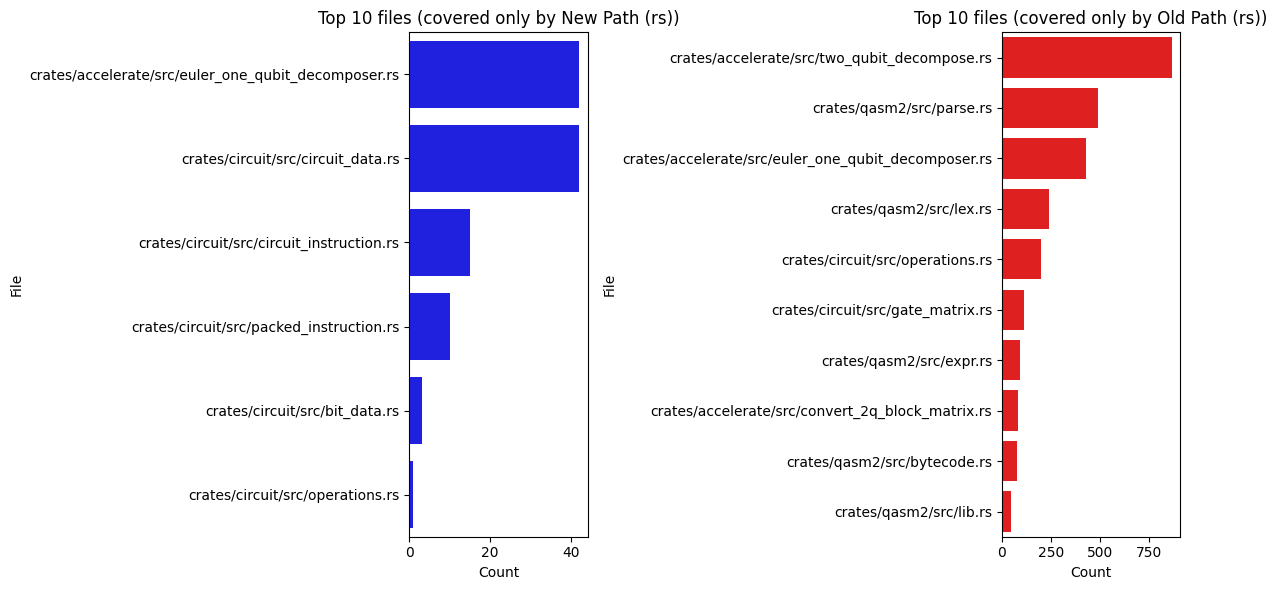

In [41]:


print("-" * 80)
print("Python and Rust Comparison:")


for postfix in ["py", "rs"]:
    print(f"\n{postfix.upper()} files comparison:")
    # keep only python or rust lines based on postfix
    covered_lines_new_postfix = [
        line for line in covered_lines_new if f".{postfix}:" in line]
    covered_lines_old_postfix = [
        line for line in covered_lines_old if f".{postfix}:" in line]
    covered_lines_old_rerun_postfix = [
        line for line in covered_lines_old_rerun if f".{postfix}:" in line]

    print(f"\nCovered Lines Comparison (New vs Old Path) ({postfix}):")
    # Compare covered lines between new and old paths
    compare_sets(covered_lines_new_postfix, covered_lines_old_postfix,
                 f"New Path ({postfix})", f"Old Path ({postfix})")

    # print(f"\nCovered Lines Comparison (Old vs Old Path Rerun) ({postfix}):")
    # # Compare covered lines between old and old path rerun
    # compare_sets(covered_lines_old_postfix, covered_lines_old_rerun_postfix, f"Old Path ({postfix})", f"Old Path Rerun ({postfix})")

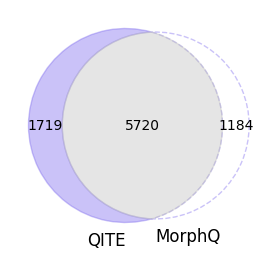

\newcommand{\QITEQiskitCoverage}{10.23\%}
\newcommand{\MorphQQiskitCoverage}{9.49\%}
\newcommand{\QITEQiskitTotalLines}{72751}
\newcommand{\MorphQQiskitTotalLines}{72751}
\newcommand{\QITEQiskitCoveredLines}{7439}
\newcommand{\MorphQQiskitCoveredLines}{6904}
\newcommand{\CoveredSharedLines}{5720}
\newcommand{\CoveredOnlyQITE}{1719}
\newcommand{\CoveredOnlyMorphQ}{1184}


In [11]:
from matplotlib_venn import venn2
import seaborn as sns

import matplotlib.pyplot as plt


def plot_covered_lines_venn(
        set1: set, set2: set, label1: str, label2: str) -> Tuple[
        plt.Figure, plt.Axes]:
    """
    Plot a Venn diagram showing the intersection between two sets of covered lines.

    Args:
        set1 (set): First set of covered lines.
        set2 (set): Second set of covered lines.
        label1 (str): Label for the first set.
        label2 (str): Label for the second set.

    Returns:
        Tuple[plt.Figure, plt.Axes]: The figure and axes of the Venn diagram.
    """
    # Compute the intersection and differences
    only_set1 = set1 - set2
    only_set2 = set2 - set1
    intersection = set1 & set2

    # Create the Venn diagram
    fig, ax = plt.subplots(figsize=(6, 3))
    venn = venn2([set1, set2], (label1, label2), ax=ax)

    # Set colors using seaborn palette
    # colors = sns.color_palette("tab10", 3)
    venn.get_label_by_id('10').set_text(len(only_set1))
    venn.get_label_by_id('01').set_text(len(only_set2))
    venn.get_label_by_id('11').set_text(len(intersection))

    # Set colors
    venn.get_patch_by_id('10').set_color(colors[0])
    venn.get_patch_by_id('01').set_edgecolor(colors[0])
    venn.get_patch_by_id('01').set_linestyle('dashed')
    venn.get_patch_by_id('01').set_facecolor('white')
    venn.get_patch_by_id('11').set_color(colors[2])

    # Add title
    plt.show()

    return fig, ax


# Example usage
set_our_approach = set(covered_lines_our_approach)
set_morphq = set(covered_lines_morphq_1h)
fig, ax = plot_covered_lines_venn(
    set_our_approach, set_morphq, 'QITE', 'MorphQ')

# Save the Venn diagram as an image with a meaningful name
output_path_venn = os.path.join(
    "images", "comparison_morphq_covered_lines_venn_w_rust.pdf")
fig.savefig(output_path_venn)

print(
    f"\\newcommand{{\\QITEQiskitCoverage}}{{{package_coverage_ours['qiskit']['coverage']:.2f}\\%}}")
print(
    f"\\newcommand{{\\MorphQQiskitCoverage}}{{{package_coverage_morphq['qiskit']['coverage']:.2f}\\%}}")

print(
    f"\\newcommand{{\\QITEQiskitTotalLines}}{{{package_coverage_ours['qiskit']['total']}}}")
print(
    f"\\newcommand{{\\MorphQQiskitTotalLines}}{{{package_coverage_morphq['qiskit']['total']}}}")

print(
    f"\\newcommand{{\\QITEQiskitCoveredLines}}{{{package_coverage_ours['qiskit']['covered']}}}")
print(
    f"\\newcommand{{\\MorphQQiskitCoveredLines}}{{{package_coverage_morphq['qiskit']['covered']}}}")

# Calculate the number of lines in each category
num_shared_lines = len(set_our_approach & set_morphq)
num_only_qite = len(set_our_approach - set_morphq)
num_only_morphq = len(set_morphq - set_our_approach)

print(f"\\newcommand{{\\CoveredSharedLines}}{{{num_shared_lines}}}")
print(f"\\newcommand{{\\CoveredOnlyQITE}}{{{num_only_qite}}}")
print(f"\\newcommand{{\\CoveredOnlyMorphQ}}{{{num_only_morphq}}}")

In [18]:
import subprocess
from functools import lru_cache


@lru_cache(maxsize=128)
def get_docker_file_line_info(file_path: str, line_number: str) -> str:
    command = f"docker run --rm qiskit_w_rust /bin/bash -c \"sed -n '{line_number}p' {file_path}\""
    result = subprocess.run(command, shell=True,
                            capture_output=True, text=True)
    return result.stdout.strip()


for line in sorted(diff_morphq)[:25]:
    file_path, line_number = line.split(':')
    file_path = f"qiskit/{file_path}"
    print("-" * 80)
    print(line)
    print(get_docker_file_line_info(file_path, line_number))

--------------------------------------------------------------------------------
circuit/bit.py:60
def __repr__(self):
--------------------------------------------------------------------------------
circuit/bit.py:62
if (self._register, self._index) == (None, None):
--------------------------------------------------------------------------------
circuit/bit.py:64
return object.__repr__(self)
--------------------------------------------------------------------------------
circuit/bit.py:65
return self._repr
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:106
def __repr__(self):
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:107
return f"Cast({self.operand}, {self.type}, implicit={self.implicit})"
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:177
def __repr__(self):
-----------------------------